In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import tejapi
import os 
tejapi.ApiConfig.api_key = ""
tejapi.ApiConfig.ignoretz=True

所輸入的項目:
scr:總分   scrd:ADE減分   scl:規模
ern:獲利   saf:安全   act:效率   roe:淨值報酬%   
roa:資產報酬%   a_acid:速動比率   int_r:利息支出率   
cfo:營業活動之現金流量   xcsh:現金充裕度   
a_ov_i:過度投資額	   tt1:升降   mt_div:現金股利(元)	
mt_cash;現金認購%   cashback:減資每股退還現金	   

In [2]:
#此部分僅列出 檔名對應哪一支股票代碼

path = "C:/Users/temp.fin/Desktop/多事件影響投報分析/raw_events"


os.chdir(path)
all_coid = None

for filename in os.listdir(os.getcwd()):
    events = pd.read_csv(filename)
    for EVENT_NO in events['coid'].unique():
        roi_all = pd.DataFrame(columns=['coid','filename'])
        roi_all['coid'] = events['coid'].values
        roi_all['filename'] = filename.strip('.csv') 
        roi_all = roi_all.drop_duplicates(subset=['coid'], keep='first',inplace=False)
        if all_coid is None:
            all_coid = roi_all
        else:        
            all_coid = all_coid.append(roi_all)

all_coid = all_coid.reset_index(drop=True)   
all_coid.to_excel("C:/Users/temp.fin/Desktop/多事件影響投報分析/filename_to_coid.xls")
print('done')


done


In [3]:
# 建立市場迴歸函數 (CAMP)
def linreg(x,y):
    
    x = sm.add_constant(x)  #增加常數項
    model = sm.OLS(y,x).fit()
    return model.params[0] , model.params[1]

In [4]:
# 將輸入的事件來計算A,B 值
def train_data(events):
    events_day = events[events['DATE_NO'] == 0]
    test_data = None
    for row in events_day.index: 
        event_no = events.loc[row,'EVENT_NO']
        data_target = events.iloc[row:row+100,]
        test = data_target[np.logical_or(data_target['DATE_NO'] != 0 , data_target.index == row )]
        if(test.shape[0]>90):
            this_sample = test.copy()
            sigma = np.std(this_sample.loc[(this_sample['roi'].isnull()==False)&(this_sample['DATE_NO']!=0),'roi'].values)
            mu = np.mean(this_sample.loc[(this_sample['roi'].isnull()==False)&(this_sample['DATE_NO']!=0),'roi'].values)
            this_sample['sigma'] = sigma
            this_sample['mu'] = mu
            this_sample['roi_c'] = this_sample['roi'].astype(np.float64)
            this_sample['roi_std'] = (this_sample['roi'] - this_sample['mu'])/this_sample['sigma']
            this_sample['roi_ctd'] = (this_sample['roi_c'] - this_sample['mu'])/this_sample['sigma']
            regress_ans = linreg(this_sample.loc[(this_sample['roi'].isnull()==False)&(this_sample['DATE_NO']!=0),'roi_m'].values,
                                 this_sample.loc[(this_sample['roi'].isnull()==False)&(this_sample['DATE_NO']!=0),'roi'].values)
       
            this_sample['alpha'] = regress_ans[0]
            this_sample['beta'] = regress_ans[1]
            this_sample['roi_p'] = this_sample['alpha'] + this_sample['beta']*this_sample['roi_m']
            this_sample['roi_p_std'] =(this_sample['roi_p'] - this_sample['mu'])/this_sample['sigma'] 
            if test_data is None:
                test_data = this_sample[this_sample['EVENT_NO']==event_no]
            else:
                test_data = test_data.append(this_sample[this_sample['EVENT_NO']==event_no])   
        
    
    #final_data = test_data[test_data['DATE_NO']== 0]; return test_data
    #final_data.to_excel("C:/Users/temp.fin/Desktop/final_data.xls")
    test_data['noise'] = test_data['roi_p_std']-test_data['roi_ctd']
    return test_data

In [ ]:
path = "C:/Users/temp.fin/Desktop/多事件影響投報分析/raw_events"
os.chdir(path)

Normality_coid = None
Non_N_coid =  None
index = 0

print("共 :" + str(len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]))
      +" 個檔案") 

for filename in os.listdir(os.getcwd()):
    index=index+1
    print("已處理 :" + str(index) + "個  " +filename , end=" ") 
    
    events = pd.read_csv(filename)
    if(len(events)<100):
        print("訓練期不足")
        continue
    else:       
        test_data = train_data(events)
        print(test_data.iloc[1,3])
            
        for EVENT_NO in test_data['EVENT_NO'].unique():
            this_sample =  test_data[test_data['EVENT_NO'] == EVENT_NO] 
            if(len(this_sample['noise'])>3):   #單次事件發生有為期三天以上才討論是否常態
                # p-value > 0.05，資料符合常態分布。
                if(stats.shapiro(this_sample['noise'])[1] <= 0.05):  
                    
                    this_sample.to_excel("C:/Users/temp.fin/Desktop/多事件影響投報分析/Non_N_coid_events/coid"
                                         + str(this_sample.iloc[1,3])+"_events"+str(EVENT_NO)+".xls")
                    if Non_N_coid is None:
                        Non_N_coid = this_sample
                    else:
                        Non_N_coid = Non_N_coid.append(this_sample) 
                
                else:        
                    this_sample.to_excel("C:/Users/temp.fin/Desktop/多事件影響投報分析/Normality_coid_events/coid"
                                         + str(this_sample.iloc[1,3])+"_events"+str(EVENT_NO)+".xls")
                    if Normality_coid is None:
                        Normality_coid = this_sample
                    else:
                        Normality_coid = Normality_coid.append(this_sample) 
print("done")

共 :1702 個檔案
已處理 :1個  event1.csv 5345
已處理 :2個  event10.csv 9950
已處理 :3個  event100.csv 3325
已處理 :4個  event1000.csv 2514
已處理 :5個  event1001.csv 2509
已處理 :6個  event1002.csv 2506
已處理 :7個  event1003.csv 2504
已處理 :8個  event1004.csv 2501
已處理 :9個  event1005.csv 2499
已處理 :10個  event1006.csv 2496
已處理 :11個  event1007.csv 2495


符合常態者 : 504
不符合常態者 : 1158


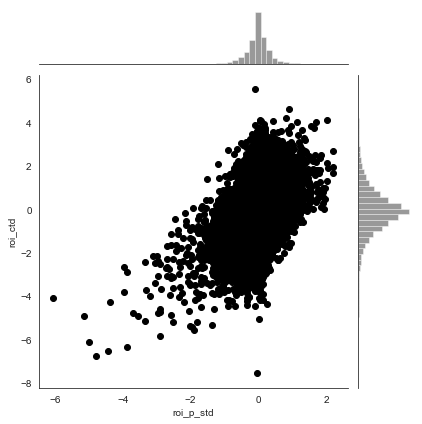

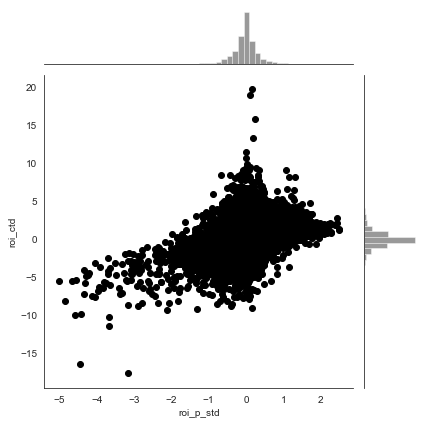

In [93]:
print(coid)
print(coid_nnorm)
print("符合常態者 : " + str(len(coid)) )
print("不符合常態者 : " + str(len(coid_nnorm)) )

#符合常態者，相關性的形狀
x = Normality_coid['roi_p_std'] 
y = Normality_coid['roi_ctd']
with sns.axes_style("white"):
    sns.jointplot(x=x, y=y, color="k");
    plt.show()

#不符合常態者，相關性的形狀
x = Non_N_coid['roi_p_std'] 
y = Non_N_coid['roi_ctd']
with sns.axes_style("white"):
    sns.jointplot(x=x, y=y, color="k");
    plt.show()
    
    
t_test= stats.ttest_ind(Normality_coid['roi_p_std'], Normality_coid['roi_ctd']) 
print('T檢定-T值：', t_test[0] )
print('T檢定-P值：', t_test[1] )

#無母數檢定
w_test = stats.wilcoxon( Normality_coid['roi_p_std'], Normality_coid['roi_ctd'])
print('無母數檢定-P值：', w_test[1] )